# Project Description

See the github ReadMe and the paper to understand this notebook.

# 1. Importing all the needed libraries

In [62]:
# new lines

TF_USE_LEGACY_KERAS=True
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"


In [93]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dense, SimpleRNN, LSTM, GRU, Masking, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import json
from tensorflow.keras import models, optimizers, losses, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random


# 2. Downloading datasets

In [64]:
def load_data(filename):
    with open(filename) as f:
        header = f.readline()
        labels = []
        points = []
        for line in f.readlines():
            data = line.split(',')
            labels.append(int(data[0]))
            points.append([int(x) for x in data[1:]])
        points = np.array(points)
        labels = np.array(labels)
        return points, labels

def get_spotify_data(songs_path, playlists_path):

  songs = {}
  playlists = []

  with open(songs_path, 'r') as f:
      songs_json = json.load(f)
      songs = songs_json

  print("Number of songs:", len(songs))

  playlist_data = [[]]

  with open(playlists_path, 'r') as f:
      playlist_json = json.load(f)
      playlist_data += playlist_json

  return songs, playlist_data[1:]


from google.colab import drive
drive.mount('/content/drive')

#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_files = 'Machine Learning Datasets/'
sys_path = prefix + customized_path_to_files
sys.path.append(sys_path)
# print(sys.path)

songs_path = os.path.join(sys_path, 'song_data0.json')
playlists_path = os.path.join(sys_path, 'playlist_data0.json')
print('Path to training data: {}'.format(songs_path))
print('Path to testing data: {}'.format(playlists_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to training data: /content/drive/My Drive/Machine Learning Datasets/song_data0.json
Path to testing data: /content/drive/My Drive/Machine Learning Datasets/playlist_data0.json


In [65]:
songs, playlists = get_spotify_data(songs_path, playlists_path)

Number of songs: 34434


# 3. Prepare the data

In [66]:
def extract_features(song_data):
    loudness = song_data["loudness"] / -60 if song_data["loudness"] <= 0.0 else 0
    features = [
        song_data["acousticness"],
        song_data["danceability"],
        song_data["energy"],
        song_data["instrumentalness"],
        song_data["mode"],
        song_data["speechiness"],
        song_data["valence"],
        # these featues below need to be standardized (between 0-1)
        song_data["time_signature"] / 5,#range from 0-5 in data
        loudness, #range from -60-2.5
        song_data["liveness"], #range from 0-1
        (song_data["key"] + 1) / 12, #range from -1 to 12
        song_data["tempo"], #range from 0-219.297 this and duration are handled later
        song_data["duration_ms"], #range from 3056.0 2424190.0
    ]

    return np.array(features)

In [67]:
def normalize_data(arr):
  min_val = np.min(arr)
  max_val = np.max(arr)
  return (arr - min_val) / (max_val - min_val)

In [68]:
def make_genre_vector(song_uri, genre_counts):
  genres = songs[song_uri]['related_genres']
  l = [int(genre in genres) for genre in genre_counts.keys()]

  while len(l) < 8: #change as needed depending on how long the genre vector will be
    l.append(0)

  return np.array(l)

def get_song_features(song_uri):
  return extract_features(songs[song_uri])
  #return np.concatenate((extract_features(songs[song_uri]), make_genre_vector(song_uri)))

In [90]:
def shuffle_arrays(array1, array2):
  # initialize arrays with same shape as parameters
  shuffled_array1 = np.empty_like(array1)
  shuffled_array2 = np.empty_like(array2)

  for i in range(array1.shape[0]):
      shuffle_indices = np.random.permutation(array1.shape[1])  # Unique shuffle indices for this slice
      shuffled_array1[i] = array1[i, shuffle_indices, :] # shuffle each along 2nd axis
      shuffled_array2[i] = array2[i, shuffle_indices, :]

  return shuffled_array1, shuffled_array2

In [70]:
# Prepare the data for all playlists and their songs
X = [[]]
playlist_genre_counts = []
for playlist in playlists:
    sorted_genre_counts = dict(sorted(playlist[2].items(), key=lambda x:x[1], reverse=True)[:8])
    #print(sorted_genre_counts)
    #[num songs x 13]
    playlist_vector = [[]]
    #print("Number of songs in playlist:", len(playlist[0]))
    for song_uri in playlist[0]:
            if song_uri in songs:
                combined_vector = get_song_features(song_uri)
                #print(songs[song_uri]["related_genres"])
                #print(combined_vector)
                genre_vector = make_genre_vector(song_uri, sorted_genre_counts)
                #print(genre_vector)
                combined_vector = np.concatenate((combined_vector, genre_vector))
                #print(combined_vector)
                playlist_vector.append(combined_vector)
    X.append(playlist_vector[1:])

    playlist_genre_counts.append(playlist[2])

print(len(playlist_genre_counts))
print((playlist_genre_counts[0]))
print(len(X))
print(len(X[1][0]))
X = X[1:]

1000
{'dance pop': 25, 'hip hop': 2, 'hip pop': 4, 'neo soul': 1, 'pop rap': 5, 'r&b': 14, 'rap': 8, 'urban contemporary': 9, 'virginia hip hop': 1, 'pop': 29, 'reggae fusion': 1, 'atl hip hop': 3, 'contemporary r&b': 2, 'south carolina hip hop': 2, 'girl group': 4, 'dirty south rap': 1, 'old school atlanta hip hop': 1, 'southern hip hop': 2, 'canadian latin': 1, 'canadian pop': 6, 'post-teen pop': 7, 'trap': 1, 'candy pop': 2, 'lilith': 2, 'new wave pop': 1, 'pop rock': 4, 'permanent wave': 2, 'singer-songwriter': 1, 'neon pop punk': 6, 'pop punk': 6, 'texas pop punk': 1, 'boy band': 2, 'pixie': 1, 'trap queen': 1, 'eurodance': 1, 'europop': 1, 'german techno': 1, 'melbourne bounce international': 1, 'escape room': 1, 'indietronica': 1, 'new rave': 1, 'alternative rock': 1, 'dance rock': 1, 'modern rock': 3, 'rock': 2, 'alternative metal': 2, 'punk': 1, 'socal pop punk': 1, 'neo mellow': 2, 'post-grunge': 1, 'piano rock': 2}
1001
21


In [95]:
# takes each set b, adds random songs until b is length n_b, and creates labels
def append_b_tracks(a, B, n):
  n_vector = []
  for i, b in enumerate(B):
    l = len(b)
    #print("Length of b", l)
    n_vector.append(l)
    needed_tracks = n - l
    #print(needed_tracks)
    a[i], B[i] = append_rand_tracks(a[i], b, needed_tracks, i)
    #part below standardizes the last few features that need it
    nai = np.array(a[i])
    #print(i, nai.shape)
    #print(nai[0], type(a[i]))
    #print(i, nai.shape, len(a[i]), len(a[i][0]), B[i].shape)
    tempos_a = np.array([single_song[11] for single_song in a[i]])
    tempos_b = np.array([b[11] for b in B[i]])
    tempos = np.concatenate((tempos_a, tempos_b))
    #print(tempos.shape)
    duration_ms_a = np.array([single_song[12] for single_song in a[i]])
    duration_ms_b = np.array([b[12] for b in B[i]])
    duration_mss = np.concatenate((duration_ms_a, duration_ms_b))
    #print(duration_mss.shape)
    normalized_tempos = normalize_data(tempos)
    normalized_duration = normalize_data(duration_mss)
    B[i][:, 11] = normalized_tempos[-20:]
    nai[:, 11] = normalized_tempos[:-20]
    B[i][:, 12] = normalized_duration[-20:]
    nai[:, 12] = normalized_duration[:-20]
    a[i] = nai

  # Loop through each value in b to create the desired labels
  result_arrays = []
  for n in n_vector:
    b_results = np.zeros(20, dtype=int)
    b_results[:n] = 1
    result_arrays.append(b_results)

  # Convert the list of arrays to a 2D NumPy array
  result_arrays = np.array(result_arrays)
  #print(result_arrays)
  # Convert 2D array into a 3D array
  labels = result_arrays[:, :, np.newaxis]
  #for i in range(5):
  # print(n_vector[i], labels[i])

  return B, labels


def append_rand_tracks(a, b, n, i):
  song_uris = np.array(list(songs.keys()))
  random_uris = np.random.choice(song_uris, n, replace=False)
  #print(len(a), len(b))

  sorted_genre_counts = dict(sorted(playlist_genre_counts[i].items(), key=lambda x:x[1], reverse=True)[:8])
  for uri in random_uris:
    genre_vector = genre_vector = make_genre_vector(song_uri, sorted_genre_counts)
    feature_vector = get_song_features(uri)
    feature_vector = np.concatenate((feature_vector, genre_vector))
    #print(feature_vector.shape)
    b = np.vstack((b, feature_vector))
  return a,np.array(b)

In [72]:
print(len(X))
max_length = max(len(x) for x in X)
print(f"Max Length: {max_length}")
min_length = min(len(x) for x in X)
print(f"Min Length: {min_length}")

# Create a and b
a = []
b = []
for x in X:
  l = len(x)
  random_number = random.randint(2, 20)
  if (20 > l) or random_number >= l:
    random_number = random.randint(7, 12)#int(l * (l / random_number))
    if random_number >= l:
      random_number = random.randint(2, l - 1)
  #print(random_number, l)
  a.append(x[random_number:])
  b.append(x[:random_number])
  #print(random_number)
print(len(a), len(b))

1000
Max Length: 245
Min Length: 5
1000 1000


In [73]:
print(len(a), len(a[0][0]))
print(len(b), len(b[0][0]))
b, labels = append_b_tracks(a, b, 20)
print("finished adding tracks b")


1000 21
1000 21
finished adding tracks b


In [74]:
#print(len(a[0]))
#print(len(a[100]))
#print(b[0][:, 11])
#print(a[0][:, 11])
#print(b[100][:, 11])
#print(a[100][:, 11])
print(len(a))
print(np.array(b).shape)

1000
(1000, 20, 21)


In [75]:
max_length_a = max(len(x) for x in a)
print(max_length_a)
max_length_b = max(len(x) for x in b)
print(max_length_b)

#pad a and shuffle b and its labels
a_padded = pad_sequences(a, maxlen=max_length_a, padding='post', dtype='float32')
print(a_padded.shape)
print(len(b))
b = np.array(b)

print(b.shape)
#print(labels[0])
#print(labels[1])
#print(labels[2])

shuffled_b, shuffled_labels = shuffle_arrays(b, labels)


232
20
(1000, 232, 21)
1000
(1000, 20, 21)


# Building and Training the Models

# 4. Defining RNN Set Model and DNN Set Model

In [89]:
class RNNSetModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_layers, hidden_dim, output_dim):
        super(RNNSetModel, self).__init__()

        # Item encoder for set a (outputs latent representation of a)
        layers_a = [tf.keras.layers.Input(shape=input_dim),
                    tf.keras.layers.Masking(mask_value=0.0),
                    tf.keras.layers.LSTM(hidden_dim, return_sequences=False)]
        self.item_encoder_a = tf.keras.Sequential(layers_a)

        # Item encoder for set b
        # Because the shape is (n_p, n_b, n_f) and the dense layer typically expects data in a 2D format
        # Tensorflow automatically accounts for this and processes each playlist individually, passing in
        # the playlist to the model with the shape (n_b, n_f) and combining all those outputs (each with shape
        # (n_b, hiddem_dim)) from each playlist to return the shape (n_p, n_b, n_f)
        layers_b = [tf.keras.layers.Dense(hidden_dim, activation='relu')]
        for hidden_layer in range(hidden_layers):
          layers_b.append(tf.keras.layers.Dense(hidden_dim, activation='relu'))
          layers_b.append(tf.keras.layers.Dropout(0.3))
        self.item_encoder_b = tf.keras.Sequential(layers_b)

        # Scoring sub-model
        layers_s = [tf.keras.layers.Dense(2 * hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(output_dim, activation='sigmoid')]
        self.scoring_layer = tf.keras.Sequential(layers_s)

    def call(self, inputs):
        set_a, set_b = inputs  # set_a: (batch_size, n_a, input_dim), set_b: (batch_size, n_b, input_dim)

        # Encode (get latent representation for) each item in set a and b
        encoded_a_items = self.item_encoder_a(set_a)  # (batch_size, n_a, hidden_dim)
        #print("A shape", encoded_a_items.shape)
        encoded_b_items = self.item_encoder_b(set_b)  # (batch_size, n_b, hidden_dim)
        #print("B shape", encoded_b_items.shape)


        # Combine set a's representation with each item in set b
        set_a_representation_expanded = tf.expand_dims(encoded_a_items, axis=1)  # (batch_size, 1, hidden_dim)
        set_a_representation_tiled = tf.tile(set_a_representation_expanded, [1, tf.shape(set_b)[1], 1])  # (batch_size, n_b, hidden_dim)
        combined = tf.concat([encoded_b_items, set_a_representation_tiled], axis=-1)  # (batch_size, n_b, 2 * hidden_dim)

        # Score each item in set b
        scores = self.scoring_layer(combined)  # (batch_size, n_b, output_dim)
        return scores


In [88]:
class DNNSetModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_layers, hidden_dim, output_dim):
        super(DNNSetModel, self).__init__()

        # Item encoder for set a
        layers_a = [tf.keras.layers.Dense(hidden_dim, activation='relu')]
        for hidden_layer in range(hidden_layers):
          layers_a.append(tf.keras.layers.Dense(hidden_dim, activation='relu'))
          layers_a.append(tf.keras.layers.Dropout(0.3))
        self.item_encoder_a = tf.keras.Sequential(layers_a)

        # Item encoder for set b
        layers_b = [tf.keras.layers.Dense(hidden_dim, activation='relu')]
        for hidden_layer in range(hidden_layers):
          layers_b.append(tf.keras.layers.Dense(hidden_dim, activation='relu'))
          layers_b.append(tf.keras.layers.Dropout(0.3))
        self.item_encoder_b = tf.keras.Sequential(layers_b)

        # Scoring sub-model
        layers_s = [tf.keras.layers.Dense(2 * hidden_dim, activation='relu'),
                    tf.keras.layers.Dense(output_dim, activation='sigmoid')]
        self.scoring_layer = tf.keras.Sequential(layers_s)

    def call(self, inputs):
        set_a, set_b = inputs  # set_a: (batch_size, n_a, input_dim), set_b: (batch_size, n_b, input_dim)

        # Encode each item in set a
        encoded_a_items = self.item_encoder_a(set_a)  # (batch_size, n_a, hidden_dim)
        #print("Encoded shape is", encoded_a_items.shape)

        # helper method to calcualte mean excluding padded latent representations
        def generate_mean_representation(tensor):
          mask = tf.reduce_any(tensor != 0, axis=-1) # Mask for non-zero values
          lengths = tf.reduce_sum(tf.cast(mask, tf.float32), axis=1) # Count non-zero lengths
          means = tf.reduce_sum(tensor, axis=1) / tf.expand_dims(lengths, axis=-1) # Calculate mean excluding padding
          return means

        # Aggregate set a into a single vector
        set_a_representation = generate_mean_representation(encoded_a_items) # (batch_size, hidden_dim)
        #print("Shape is", set_a_representation.shape)

        # Encode each item in set b
        encoded_b_items = self.item_encoder_b(set_b)  # (batch_size, n_b, hidden_dim)

        # Combine set a's representation with each item in set b
        set_a_representation_expanded = tf.expand_dims(set_a_representation, axis=1)  # literally (batch_size, hidden_dim) in practice
                                                                                      # but in theory (batch_size, 1, hidden_dim)
                                                                                      # same in model above
        #print("Representation shape is", set_a_representation.shape)
        set_a_representation_tiled = tf.tile(set_a_representation_expanded, [1, tf.shape(set_b)[1], 1])  # (batch_size, n_b, hidden_dim)
        #print("Tiled shape is", set_a_representation_tiled.shape)
        combined = tf.concat([encoded_b_items, set_a_representation_tiled], axis=-1)  # (batch_size, n_b, 2 * hidden_dim)
        #print("Combined shape is", combined.shape)

        # Score each item in set b
        scores = self.scoring_layer(combined)  # (batch_size, n_b, output_dim)
        return scores


In [87]:
def create_DNNSetModel(input_dim, hidden_layers, hidden_dim, output_dim, epochs):
  #create and compile model
  model = DNNSetModel(input_dim, hidden_layers, hidden_dim, output_dim)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]#, tf.keras.metrics.F1Score(),]
  )

  return model

def create_RNNSetModel(input_dim, hidden_layers, hidden_dim, output_dim, epochs):
  #create and compile model
  model = RNNSetModel(input_dim, hidden_layers, hidden_dim, output_dim)
  model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]#, tf.keras.metrics.F1Score(),]
  )

  return model

# 5. Training and Testing the Models

In [83]:
#example usage with DNN set model
# data
set_a = a_padded
set_b = shuffled_b
shuffled_labels = shuffled_labels.astype(np.float32)
batch_size, n_a, input_dim = set_a.shape

print(set_a.shape)
print(set_b.shape)
#batch_size, n_a, input_dim = set_a.shape
# Instantiate the model
batch_size = 1000 #number of playlists/sets
n_b = 20 # Number of items in set b
hidden_layers = 2
hidden_dim = 64
output_dim = 1  # Binary classification
epochs = 25
model = create_DNNSetModel(input_dim, hidden_layers, hidden_dim, output_dim, 25)

training_percentage = 0.15
num_training_samples = int(training_percentage * batch_size)
X_train = [set_a[:num_training_samples], set_b[:num_training_samples]]
Y_train = shuffled_labels[:num_training_samples]
X_val = [set_a[num_training_samples:], set_b[num_training_samples:]]
Y_val = shuffled_labels[num_training_samples:]

model.fit([set_a, set_b], shuffled_labels, epochs=epochs, batch_size=batch_size)

(1000, 232, 21)
(1000, 20, 21)
Epoch 1/25
1/1 [==============================] - 5s 5s/step - loss: 0.7067 - accuracy: 0.4682 - precision: 0.6354 - recall: 0.0108
Epoch 2/25
1/1 [==============================] - 2s 2s/step - loss: 0.6939 - accuracy: 0.5089 - precision: 0.6019 - recall: 0.2386
Epoch 3/25
1/1 [==============================] - 1s 1s/step - loss: 0.6877 - accuracy: 0.5664 - precision: 0.5924 - recall: 0.6045
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.6830 - accuracy: 0.5727 - precision: 0.5674 - recall: 0.8428
Epoch 5/25
1/1 [==============================] - 1s 1s/step - loss: 0.6779 - accuracy: 0.5653 - precision: 0.5554 - recall: 0.9338
Epoch 6/25
1/1 [==============================] - 1s 1s/step - loss: 0.6730 - accuracy: 0.5630 - precision: 0.5523 - recall: 0.9612
Epoch 7/25
1/1 [==============================] - 1s 1s/step - loss: 0.6681 - accuracy: 0.5631 - precision: 0.5517 - recall: 0.9722
Epoch 8/25
1/1 [=============================

In [85]:
model = create_RNNSetModel((n_a, input_dim), hidden_layers, hidden_dim, output_dim,epochs)
model.fit([set_a, set_b], shuffled_labels, epochs=epochs, batch_size=batch_size)

Epoch 1/25
A shape (1000, 64)
(1000, 1, 64)
A shape (1000, 64)
(1000, 1, 64)
1/1 [==============================] - 9s 9s/step - loss: 0.6859 - accuracy: 0.5340 - precision: 0.5341 - recall: 0.9992
Epoch 2/25
1/1 [==============================] - 2s 2s/step - loss: 0.6779 - accuracy: 0.5352 - precision: 0.5348 - recall: 0.9985
Epoch 3/25
1/1 [==============================] - 2s 2s/step - loss: 0.6712 - accuracy: 0.5450 - precision: 0.5403 - recall: 0.9939
Epoch 4/25
1/1 [==============================] - 1s 1s/step - loss: 0.6639 - accuracy: 0.5679 - precision: 0.5541 - recall: 0.9788
Epoch 5/25
1/1 [==============================] - 2s 2s/step - loss: 0.6559 - accuracy: 0.5956 - precision: 0.5725 - recall: 0.9594
Epoch 6/25
1/1 [==============================] - 2s 2s/step - loss: 0.6474 - accuracy: 0.6283 - precision: 0.5969 - recall: 0.9371
Epoch 7/25
1/1 [==============================] - 2s 2s/step - loss: 0.6375 - accuracy: 0.6599 - precision: 0.6248 - recall: 0.9093
Epoch 8/25

In [52]:
history_opt = dict()
epochs = 25

for network_type in ['DNN']:#, 'RNN']:
  for num_hidden_layers in [0,1,2]:
    for hiddem_dim in [32, 64, 128]:#, 256, 512]:
      model_type = [network_type, num_hidden_layers, hiddem_dim]
      print("Parameters:", model_type)
      save_best_model = ModelCheckpoint('best_model.{}.keras'.format(model_type), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
      key = tuple(model_type)
      model = create_DNNSetModel((n_a, input_dim), hidden_layers, hidden_dim, output_dim, 25)
      history_opt[key] = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size,callbacks=[save_best_model])

Parameters: ['DNN', 0, 32]
Epoch 1/25
1/1 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.4980 - precision: 0.4286 - recall: 0.0080
Epoch 1: val_accuracy improved from -inf to 0.48806, saving model to best_model.['DNN', 0, 32].keras
1/1 [==============================] - 5s 5s/step - loss: 0.7030 - accuracy: 0.4980 - precision: 0.4286 - recall: 0.0080 - val_loss: 0.6972 - val_accuracy: 0.4881 - val_precision: 0.8410 - val_recall: 0.0186
Epoch 2/25
1/1 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5030 - precision: 0.5211 - recall: 0.0905
Epoch 2: val_accuracy improved from 0.48806 to 0.55976, saving model to best_model.['DNN', 0, 32].keras
1/1 [==============================] - 0s 457ms/step - loss: 0.6982 - accuracy: 0.5030 - precision: 0.5211 - recall: 0.0905 - val_loss: 0.6898 - val_accuracy: 0.5598 - val_precision: 0.8360 - val_recall: 0.1904
Epoch 3/25
1/1 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5477

In [53]:
history_opt_rnn = dict()
epochs = 25

for network_type in ['RNN']:
  for num_hidden_layers in [0,1,2]:
    for hiddem_dim in [32, 64, 128]:#, 256, 512]:
      model_type = [network_type, num_hidden_layers, hiddem_dim]
      print("Parameters:", model_type)
      save_best_model = ModelCheckpoint('best_model.{}.keras'.format(model_type), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
      model = create_RNNSetModel((n_a, input_dim), hidden_layers, hidden_dim, output_dim, 25)
      #model.fit([set_a, set_b], shuffled_labels, epochs=epochs, batch_size=batch_size)
      key = tuple(model_type)
      history_opt_rnn[key] = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size,callbacks=[save_best_model])


Parameters: ['RNN', 0, 32]
Epoch 1/25
1/1 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.4873 - precision: 0.4938 - recall: 0.9521
Epoch 1: val_accuracy improved from -inf to 0.53188, saving model to best_model.['RNN', 0, 32].keras
1/1 [==============================] - 16s 16s/step - loss: 0.6956 - accuracy: 0.4873 - precision: 0.4938 - recall: 0.9521 - val_loss: 0.6823 - val_accuracy: 0.5319 - val_precision: 0.5269 - val_recall: 0.9730
Epoch 2/25
1/1 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.5147 - precision: 0.5088 - recall: 0.8842
Epoch 2: val_accuracy improved from 0.53188 to 0.64547, saving model to best_model.['RNN', 0, 32].keras
1/1 [==============================] - 3s 3s/step - loss: 0.6859 - accuracy: 0.5147 - precision: 0.5088 - recall: 0.8842 - val_loss: 0.6731 - val_accuracy: 0.6455 - val_precision: 0.6181 - val_recall: 0.8319
Epoch 3/25
1/1 [==============================] - ETA: 0s - loss: 0.6776 - accuracy: 0.5843 

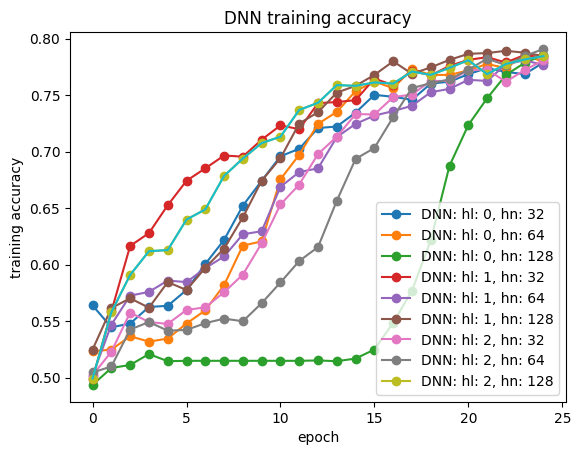

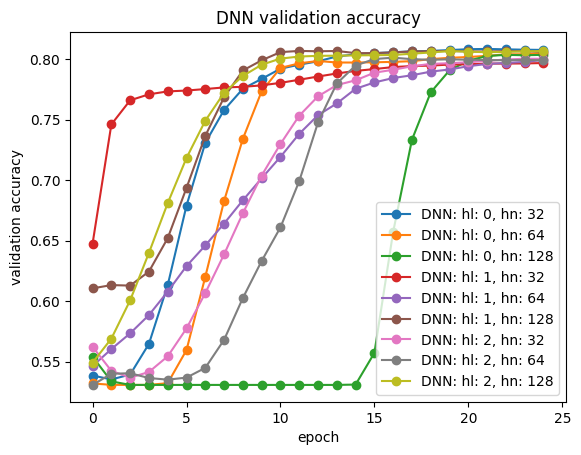

In [ ]:
# Plot training accuracy
for model_type, history in history_opt.items():
  if model_type[0] == 'DNN':
        plt.plot(history.history['accuracy'], 'o-', label='DNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.plot(history.history['accuracy'])
plt.title('DNN training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.clf()

# Plot validation accuracy
for model_type, history in history_opt.items():
  if model_type[0] == 'DNN':
    plt.plot(history.history['val_accuracy'], 'o-', label='DNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.title('DNN validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

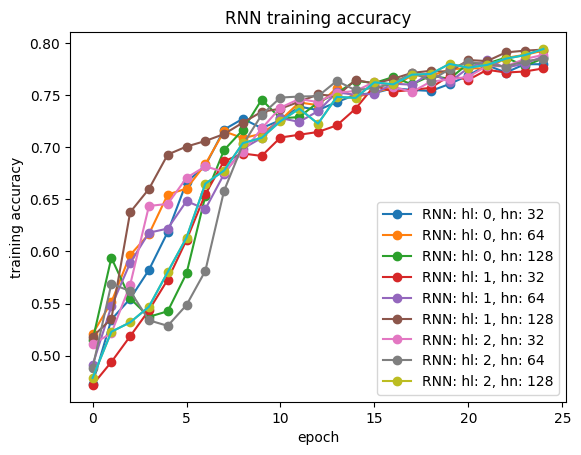

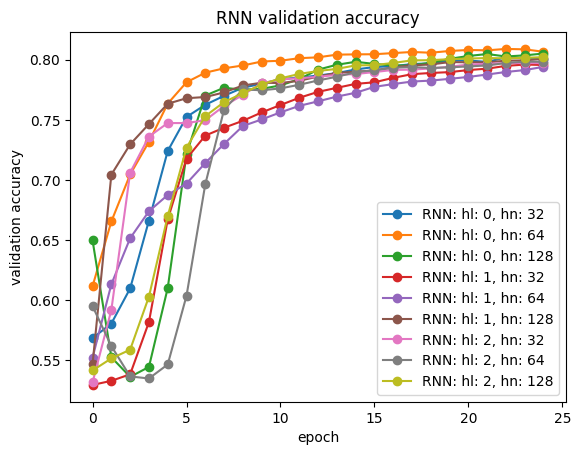

In [ ]:
# Plot training accuracy
for model_type, history in history_opt_rnn.items():
  plt.plot(history.history['accuracy'], 'o-', label='RNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.plot(history.history['accuracy'])
plt.title('RNN training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.clf()

# Plot validation accuracy
for model_type, history in history_opt_rnn.items():
  plt.plot(history.history['val_accuracy'], 'o-', label='RNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.title('RNN validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [79]:
history_opt_cmp = dict()
epochs = 25

for network_type in ['DNN']:
  for num_hidden_layers in [1,2]:
    for hiddem_dim in [512]:
      model_type = [network_type, num_hidden_layers, hiddem_dim]
      print("Parameters:", model_type)
      save_best_model = ModelCheckpoint('best_model.{}.keras'.format(model_type), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
      key = tuple(model_type)
      model = create_DNNSetModel((n_a, input_dim), hidden_layers, hidden_dim, output_dim, 25)
      history_opt_cmp[key] = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size,callbacks=[save_best_model])


for network_type in ['RNN']:
  for num_hidden_layers in [1]:
    for hiddem_dim in [512]:
      model_type = [network_type, num_hidden_layers, hiddem_dim]
      print("Parameters:", model_type)
      save_best_model = ModelCheckpoint('best_model.{}.keras'.format(model_type), monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
      model = create_RNNSetModel((n_a, input_dim), hidden_layers, hidden_dim, output_dim, 25)
      #model.fit([set_a, set_b], shuffled_labels, epochs=epochs, batch_size=batch_size)
      key = tuple(model_type)
      history_opt_cmp[key] = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size,callbacks=[save_best_model])


Parameters: ['DNN', 1, 512]
Epoch 1/25
1/1 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5130 - precision: 0.5745 - recall: 0.1052
Epoch 1: val_accuracy improved from -inf to 0.57206, saving model to best_model.['DNN', 1, 512].keras
1/1 [==============================] - 6s 6s/step - loss: 0.6962 - accuracy: 0.5130 - precision: 0.5745 - recall: 0.1052 - val_loss: 0.6892 - val_accuracy: 0.5721 - val_precision: 0.5597 - val_recall: 0.8287
Epoch 2/25
1/1 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5147 - precision: 0.5141 - recall: 0.5579
Epoch 2: val_accuracy did not improve from 0.57206
1/1 [==============================] - 1s 905ms/step - loss: 0.6920 - accuracy: 0.5147 - precision: 0.5141 - recall: 0.5579 - val_loss: 0.6844 - val_accuracy: 0.5426 - val_precision: 0.5328 - val_recall: 0.9744
Epoch 3/25
1/1 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.5507 - precision: 0.5334 - recall: 0.8176
Epoch 3: val_

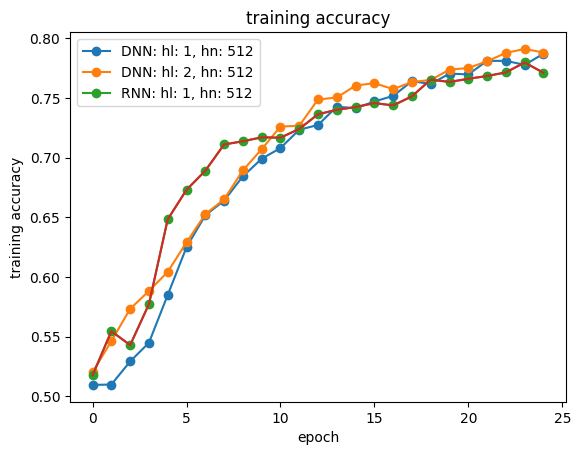

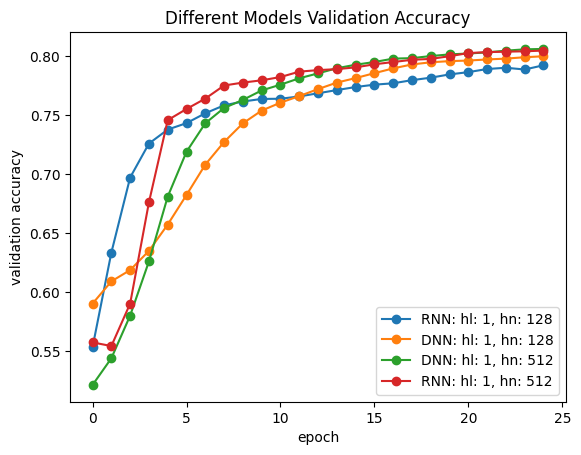

In [61]:
# Plot training accuracy
for model_type, history in history_opt_cmp.items():
  plt.plot(history.history['accuracy'], 'o-', label='{}: hl: {}, hn: {}'.format(model_type[0], model_type[1], model_type[2]))
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()
plt.clf()

# Plot validation accuracy
for model_type, history in history_opt_rnn.items():
  if model_type[1] == 1 and model_type[2] == 128:
    plt.plot(history.history['val_accuracy'], 'o-', label='{}: hl: {}, hn: {}'.format(model_type[0], model_type[1], model_type[2]))

for model_type, history in history_opt.items():
  if (model_type[1] == 1) and model_type[2] == 128:
    plt.plot(history.history['val_accuracy'], 'o-', label='{}: hl: {}, hn: {}'.format(model_type[0], model_type[1], model_type[2]))

for model_type, history in history_opt_cmp.items():
  if (model_type[1] == 1):
    plt.plot(history.history['val_accuracy'], 'o-', label='{}: hl: {}, hn: {}'.format(model_type[0], model_type[1], model_type[2]))

plt.title('Different Models Validation Accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

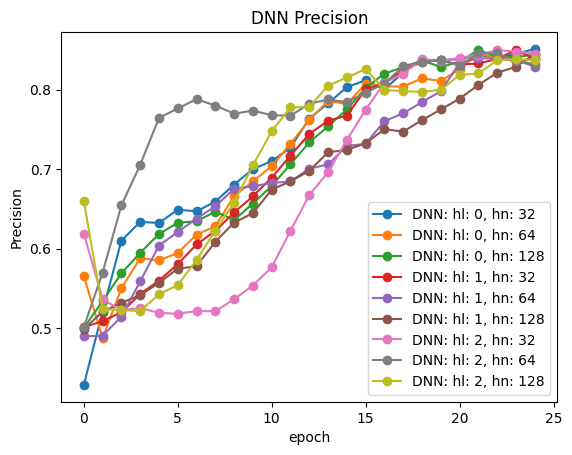

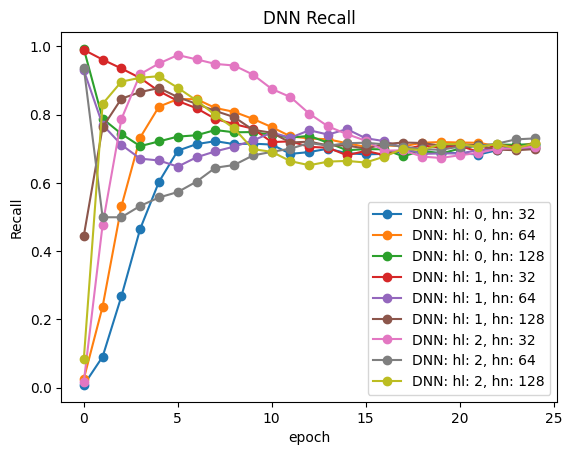

In [82]:
# Plot other metrics accuracy
graph_metric = 'precision'
for model_type, history in history_opt.items():
  if model_type[0] == 'DNN':
    plt.plot(history.history[graph_metric], 'o-', label='DNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.title('DNN Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

# Plot other metrics accuracy
graph_metric = 'recall'
for model_type, history in history_opt.items():
  if model_type[0] == 'DNN':
    plt.plot(history.history[graph_metric], 'o-', label='DNN: hl: {}, hn: {}'.format(model_type[1], model_type[2]))
plt.title('DNN Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# Print training accuracy
for model_type, history in history_opt.items():
  if model_type[0] == 'DNN':
        best_train_acc = max(history.history['accuracy'])
        best_val_acc = max(history.history['val_accuracy'])
        print(f"Model: DNN with hl: {model_type[1]}, hn: {model_type[2]}")
        print(f"Best Training Accuracy: {best_train_acc:.4f}")
        print(f"Best Validation Accuracy: {best_val_acc:.4f}\n")

Model: DNN with hl: 0, hn: 32
Best Training Accuracy: 0.7790
Best Validation Accuracy: 0.8084

Model: DNN with hl: 0, hn: 64
Best Training Accuracy: 0.7860
Best Validation Accuracy: 0.8051

Model: DNN with hl: 0, hn: 128
Best Training Accuracy: 0.7857
Best Validation Accuracy: 0.8035

Model: DNN with hl: 1, hn: 32
Best Training Accuracy: 0.7857
Best Validation Accuracy: 0.7968

Model: DNN with hl: 1, hn: 64
Best Training Accuracy: 0.7810
Best Validation Accuracy: 0.7992

Model: DNN with hl: 1, hn: 128
Best Training Accuracy: 0.7893
Best Validation Accuracy: 0.8068

Model: DNN with hl: 2, hn: 32
Best Training Accuracy: 0.7810
Best Validation Accuracy: 0.8003

Model: DNN with hl: 2, hn: 64
Best Training Accuracy: 0.7910
Best Validation Accuracy: 0.8012

Model: DNN with hl: 2, hn: 128
Best Training Accuracy: 0.7847
Best Validation Accuracy: 0.8066



In [ ]:
for model_type, history in history_opt_rnn.items():
    # Print the best training and validation accuracy
    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    print(f"Model: RNN with hl: {model_type[1]}, hn: {model_type[2]}")
    print(f"Best Training Accuracy: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}\n")

Model: RNN with hl: 0, hn: 32
Best Training Accuracy: 0.7797
Best Validation Accuracy: 0.8020

Model: RNN with hl: 0, hn: 64
Best Training Accuracy: 0.7927
Best Validation Accuracy: 0.8090

Model: RNN with hl: 0, hn: 128
Best Training Accuracy: 0.7860
Best Validation Accuracy: 0.8052

Model: RNN with hl: 1, hn: 32
Best Training Accuracy: 0.7757
Best Validation Accuracy: 0.7960

Model: RNN with hl: 1, hn: 64
Best Training Accuracy: 0.7870
Best Validation Accuracy: 0.7941

Model: RNN with hl: 1, hn: 128
Best Training Accuracy: 0.7937
Best Validation Accuracy: 0.8008

Model: RNN with hl: 2, hn: 32
Best Training Accuracy: 0.7887
Best Validation Accuracy: 0.7973

Model: RNN with hl: 2, hn: 64
Best Training Accuracy: 0.7847
Best Validation Accuracy: 0.7985

Model: RNN with hl: 2, hn: 128
Best Training Accuracy: 0.7943
Best Validation Accuracy: 0.8022



In [60]:
for model_type, history in history_opt_cmp.items():
    # Print the best training and validation accuracy
    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    print(f"Model: RNN with hl: {model_type[1]}, hn: {model_type[2]}")
    print(f"Best Training Accuracy: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}\n")

Model: RNN with hl: 1, hn: 512
Best Training Accuracy: 0.7870
Best Validation Accuracy: 0.8064

Model: RNN with hl: 2, hn: 512
Best Training Accuracy: 0.7910
Best Validation Accuracy: 0.8036

Model: RNN with hl: 1, hn: 512
Best Training Accuracy: 0.7797
Best Validation Accuracy: 0.8049

